In [107]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
import pandas as pd

btc_data = pd.read_csv('./btc_usdt_1day.csv', index_col='datetime')
def MinMaxScaler(data):
    numerator = data - np.min(data, axis = 0)
    denominator = np.max(data, 0) - np.min(data, axis = 0)
    # 0으로 나누는 걸 방지하기 위해 노이즈 추가
    return numerator / (denominator + 1e-7)
tf.test.is_built_with_cuda()

True

In [108]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [109]:
btc_data = btc_data.to_numpy()

minVec = np.min(btc_data, axis=0)
maxVec = np.max(btc_data, axis=0)
btc_data_scaled = MinMaxScaler(btc_data)
btc_data_x = btc_data_scaled
btc_data_y = btc_data_scaled[:, [-2]]

seq_len = 120
dataX = []
dataY = []
for i in range(0, len(btc_data_scaled) - seq_len):
    _x = btc_data_x[i:i + seq_len]
    _y = btc_data_y[i+seq_len]
    #print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

In [110]:
train_size = int(len(dataY) * 0.7)
valid_size = int(len(dataY) * 0.1)
test_size = len(dataY) - train_size - valid_size

trainX, validX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size: train_size + valid_size]), np.array(dataX[train_size + valid_size : len(dataX)])
trainY, validY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size: train_size + valid_size]), np.array(dataY[train_size + valid_size : len(dataX)])


In [111]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(layers.LSTM(16, input_shape=(trainX.shape[1], trainX.shape[2]),
                      kernel_initializer='glorot_normal', recurrent_initializer='random_normal', bias_initializer='he_uniform',
                      kernel_regularizer=l2(0.003), activity_regularizer=l2(0.1),
                      activation='tanh', recurrent_activation='hard_sigmoid',
                      ))
model.add(layers.Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16)                1408      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=10, batch_size=1000, verbose=1)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0565 - val_loss: 0.0563
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0485 - val_loss: 0.0467
Epoch 3/10


In [ ]:
pred = model.predict(testX[0].reshape(1, 120, 5))
pred, testY[7]

In [ ]:
pred = model.predict(testX, verbose=1)

In [ ]:
plt.plot(testY, label='Real Value')
plt.plot(pred, label='Pred Value')
plt.xlabel("Time Period")
plt.ylabel("Crypto Price")
plt.legend()
plt.show()

In [ ]:
testY_origin = minVec[-2] + testY * (maxVec[-2] - minVec[-2])
pred_origin = minVec[-2] + pred * (maxVec[-2] - minVec[-2])

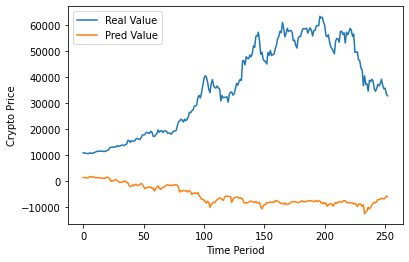

In [117]:
plt.plot(testY_origin, label='Real Value')
plt.plot(pred_origin, label='Pred Value')
plt.xlabel("Time Period")
plt.ylabel("Crypto Price")
plt.legend()
plt.show()

In [118]:
model.save('model_final_1day.h5')

In [26]:
np.max(testY_origin, axis=0)

array([64800.])